<a href="https://colab.research.google.com/github/Nguyen379/Mask_detection/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pwd

'/content'

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection"

/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection


In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection'

In [ ]:
%ls


 Analyze_data.ipynb    masks_no_improper/     Ref_image.png
'Face Mask Dataset'/   model_checkpoint/      scores/
 haarcascade/          Model_training.ipynb


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import time

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection/Face Mask Dataset/Train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection/Face Mask Dataset/Test"
val_dir = "/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection/Face Mask Dataset/Validation"

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

In [ ]:
tf.__version__

'2.7.0'

Ko dung vertical flip,
Can split thi subset

# EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# The Keras ResNet pretrained weights are learned on a dataset with 
#different preprocessing than Inception or VGG.
# It seems similar to Efficientnet

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  batch_size=32,
                                                  shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 10040 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
efn = EfficientNetB0(weights="imagenet", 
                     include_top = False, 
                     input_shape = (224,224,3))
for layer in efn.layers:
    layer.trainable = False

model = Sequential()
model.add(efn)
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 4,175,013
Trainable params: 125,442
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
patient = 4
save_path = "model_checkpoint/efn.h5"
callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(save_path, 
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1,
                    save_best_only=True)
    ]



In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics ="accuracy")

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9875
Epoch 00001: val_accuracy improved from -inf to 0.99875, saving model to model_checkpoint/efn.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


314/314 [==============================] - 197s 603ms/step - loss: 0.0678 - accuracy: 0.9875 - val_loss: 0.0249 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9935
Epoch 00002: val_accuracy did not improve from 0.99875
314/314 [==============================] - 181s 578ms/step - loss: 0.0539 - accuracy: 0.9935 - val_loss: 0.0784 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9950
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_accuracy did not improve from 0.99875
314/314 [==============================] - 184s 585ms/step - loss: 0.0460 - accuracy: 0.9950 - val_loss: 0.0819 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9961
Epoch 00004: val_accuracy did not improve from 0.99875
314/314 [=============

In [ ]:
total_time = time.time()-start
print(total_time)
# 1828.9590902328491

1828.9590902328491


In [ ]:
model.evaluate_generator(test_generator)
# [0.011287834495306015, 0.9962499737739563]# 1828.9590902328491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.011287834495306015, 0.9962499737739563]

In [ ]:
import pickle
with open('scores/efn.pkl', 'wb') as f:
  pickle.dump(history.history, f)

# Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  batch_size=32,
                                                  shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 10040 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
inception = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224,224,3))

for layer in inception.layers:
    layer.trainable = False
    
model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 2)                 102402    
                                                                 
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
patient = 4
save_path = "model_checkpoint/inceptionv3.h5"
callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=1e-5,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(save_path, 
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1,
                    save_best_only=True)
    ]
                    

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics ="accuracy")

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9840
Epoch 00001: val_accuracy improved from -inf to 0.99750, saving model to model_checkpoint/inceptionv3.h5
314/314 [==============================] - 1269s 4s/step - loss: 0.1064 - accuracy: 0.9840 - val_loss: 0.0164 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9898
Epoch 00002: val_accuracy did not improve from 0.99750
314/314 [==============================] - 186s 591ms/step - loss: 0.1414 - accuracy: 0.9898 - val_loss: 0.1894 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.9919
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_accuracy did not improve from 0.99750
314/314 [==============================] - 185s 588ms/step - loss: 0.1095 - accuracy: 0.9919 - val_loss: 0.2276 - val_accu

In [ ]:
total_time = time.time()-start
print(total_time)
# 2016.7430481910706

2016.7430481910706


In [ ]:
model.evaluate_generator(test_generator)
# [0.023700179532170296, 0.9975000023841858]# 2016.7430481910706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.023700179532170296, 0.9975000023841858]

In [ ]:
import pickle
with open('scores/inception.pkl', 'wb') as f:
  pickle.dump(history.history, f)

#ResNet50 standardization

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# The Keras ResNet pretrained weights are learned on a dataset with 
#different preprocessing than Inception or VGG.
# It seems similar to Efficientnet

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  batch_size=32,
                                                  shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 10040 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
resnet = ResNet50(weights="imagenet", 
                     include_top = False, 
                     input_shape = (224,224,3))
for layer in resnet.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
patient = 4
save_path = "model_checkpoint/resnet50_standardized.h5"
callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(save_path, 
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1,
                    save_best_only=True)
    ]
                    

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics ="accuracy")

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9870
Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to model_checkpoint/resnet50_standardized.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


314/314 [==============================] - 204s 633ms/step - loss: 0.2012 - accuracy: 0.9870 - val_loss: 0.0546 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9954
Epoch 00002: val_accuracy improved from 0.99625 to 0.99875, saving model to model_checkpoint/resnet50_standardized.h5
314/314 [==============================] - 194s 617ms/step - loss: 0.1133 - accuracy: 0.9954 - val_loss: 0.0736 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9951
Epoch 00003: val_accuracy did not improve from 0.99875
314/314 [==============================] - 192s 611ms/step - loss: 0.1352 - accuracy: 0.9951 - val_loss: 0.0472 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9966
Epoch 00004: val_accuracy did not improve from 0.99875
314/314 [==============================]

In [ ]:
total_time = time.time()-start
print(total_time)
# 2951.790164232254


2951.790164232254


In [ ]:
model.evaluate_generator(test_generator)
# [0.08243097364902496, 0.9975000023841858]# 2951.790164232254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.08243097364902496, 0.9975000023841858]

In [ ]:
import pickle
with open('scores/res_stand.pkl', 'wb') as f:
  pickle.dump(history.history, f)

# Resnet50: normalization

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  batch_size=32,
                                                  shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 10040 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
resnet = ResNet50(weights="imagenet", 
                     include_top = False, 
                     input_shape = (224,224,3))
for layer in resnet.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
patient = 4
save_path = "model_checkpoint/resnet50_norm.h5"
callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(save_path, 
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1,
                    save_best_only=True)
    ]
                    

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics ="accuracy")

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6590
Epoch 00001: val_accuracy improved from -inf to 0.61125, saving model to model_checkpoint/resnet50_norm.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


314/314 [==============================] - 210s 654ms/step - loss: 0.6700 - accuracy: 0.6590 - val_loss: 0.7862 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7430
Epoch 00002: val_accuracy improved from 0.61125 to 0.77000, saving model to model_checkpoint/resnet50_norm.h5
314/314 [==============================] - 201s 641ms/step - loss: 0.5159 - accuracy: 0.7430 - val_loss: 0.4473 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.7885
Epoch 00003: val_accuracy improved from 0.77000 to 0.84625, saving model to model_checkpoint/resnet50_norm.h5
314/314 [==============================] - 202s 642ms/step - loss: 0.4576 - accuracy: 0.7885 - val_loss: 0.3956 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.7793
Epoch 00004: val_accuracy did not improve from 0

In [ ]:
total_time = time.time()-start
print(total_time)
# 4073.5302834510803


4073.5302834510803


In [ ]:
model.evaluate_generator(test_generator)
# [0.2939472794532776, 0.8849999904632568]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.2939472794532776, 0.8849999904632568]

In [ ]:
import pickle
with open('scores/res_norm.pkl', 'wb') as f:
  pickle.dump(history.history, f)

# VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  batch_size=32,
                                                  shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True)

Found 10040 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
vgg = VGG19(weights="imagenet", 
                     include_top = False, 
                     input_shape = (224,224,3))
for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
patient = 4
save_path = "model_checkpoint/vgg19.h5"
callbacks_list = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(save_path, 
                    monitor="val_accuracy",
                    mode="max",
                    verbose=1,
                    save_best_only=True)
    ]
                    

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics ="accuracy")

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9305
Epoch 00001: val_accuracy improved from -inf to 0.96625, saving model to model_checkpoint/vgg19.h5
314/314 [==============================] - 224s 679ms/step - loss: 0.1759 - accuracy: 0.9305 - val_loss: 0.0999 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9656
Epoch 00002: val_accuracy improved from 0.96625 to 0.97250, saving model to model_checkpoint/vgg19.h5
314/314 [==============================] - 202s 643ms/step - loss: 0.0948 - accuracy: 0.9656 - val_loss: 0.0766 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9729
Epoch 00003: val_accuracy improved from 0.97250 to 0.97875, saving model to model_checkpoint/vgg19.h5
314/314 [==============================] - 203s 646ms/step - loss: 0.0767 - accuracy: 0.9729 - val_loss: 0.0606 -

In [ ]:
total_time = time.time()-start
print(total_time) 
# 3096.4909472465515

3096.4909472465515


In [ ]:
model.evaluate_generator(test_generator)
# [0.04144008085131645, 0.9837499856948853]# 3096.4909472465515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.04144008085131645, 0.9837499856948853]

In [ ]:
import pickle
with open('scores/vgg.pkl', 'wb') as f:
  pickle.dump(history.history, f)

#Plotting

In [ ]:
%pwd

'/content'

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection"

/content/drive/MyDrive/Colab Notebooks/AI4E/Final Project/Mask detection


In [ ]:
import pickle
with open('scores/efn.pkl', 'rb') as f:
    efn = pickle.load(f)
with open('scores/inception.pkl', 'rb') as f:
    incep = pickle.load(f)
with open('scores/res_stand.pkl', 'rb') as f:
    res_stand = pickle.load(f)
with open('scores/res_norm.pkl', 'rb') as f:
    res_norm = pickle.load(f)
with open('scores/vgg.pkl', 'rb') as f:
    vgg = pickle.load(f)

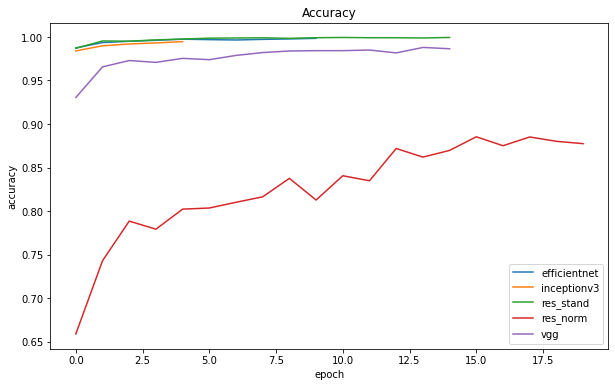

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  
plt.subplot(1,2,1)
plt.plot(efn['accuracy'], color="b", linewidth=2)
plt.plot(incep['accuracy'], color="r", linewidth=2)
plt.plot(res_stand['accuracy'], color="g", linewidth=2)  
plt.plot(res_norm['accuracy'], color="y", linewidth=2)  
plt.plot(vgg['accuracy'], color="m", linewidth=2) 

plt.title('accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'res_norm', 'vgg'], loc='lower right')  

plt.subplot(1,2,2)
plt.plot(efn['accuracy'], color="b", linewidth=2)
plt.plot(incep['accuracy'], color="r", linewidth=2)
plt.plot(res_stand['accuracy'], color="g", linewidth=2)  
plt.plot(vgg['accuracy'], color="m", linewidth=2) 

plt.title('accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'vgg'], loc='lower right') 
plt.show()

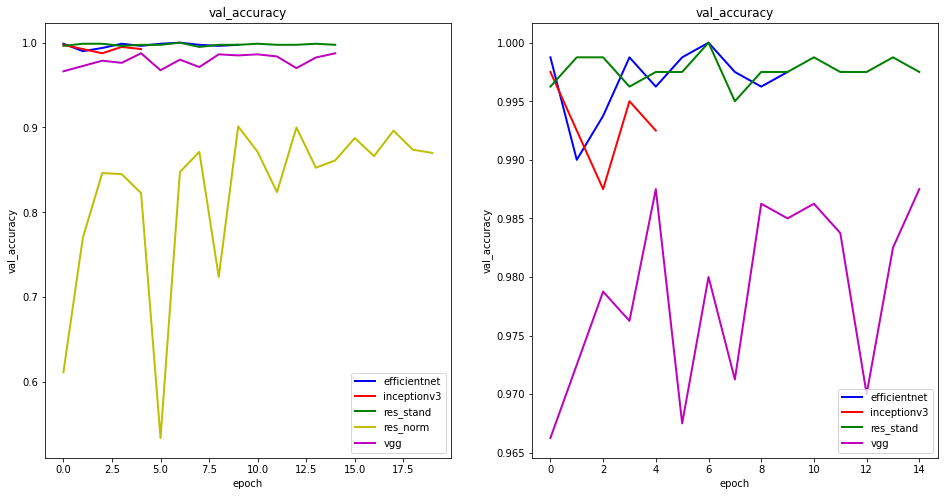

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  
plt.subplot(1,2,1)
plt.plot(efn['val_accuracy'], color="b", linewidth=2)
plt.plot(incep['val_accuracy'], color="r", linewidth=2)
plt.plot(res_stand['val_accuracy'], color="g", linewidth=2)  
plt.plot(res_norm['val_accuracy'], color="y", linewidth=2)  
plt.plot(vgg['val_accuracy'], color="m", linewidth=2) 

plt.title('val_accuracy')  
plt.ylabel('val_accuracy')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'res_norm', 'vgg'], loc='lower right')  

plt.subplot(1,2,2)
plt.plot(efn['val_accuracy'], color="b", linewidth=2)
plt.plot(incep['val_accuracy'], color="r", linewidth=2)
plt.plot(res_stand['val_accuracy'], color="g", linewidth=2)  
plt.plot(vgg['val_accuracy'], color="m", linewidth=2) 

plt.title('val_accuracy')  
plt.ylabel('val_accuracy')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'vgg'], loc='lower right') 
plt.show()

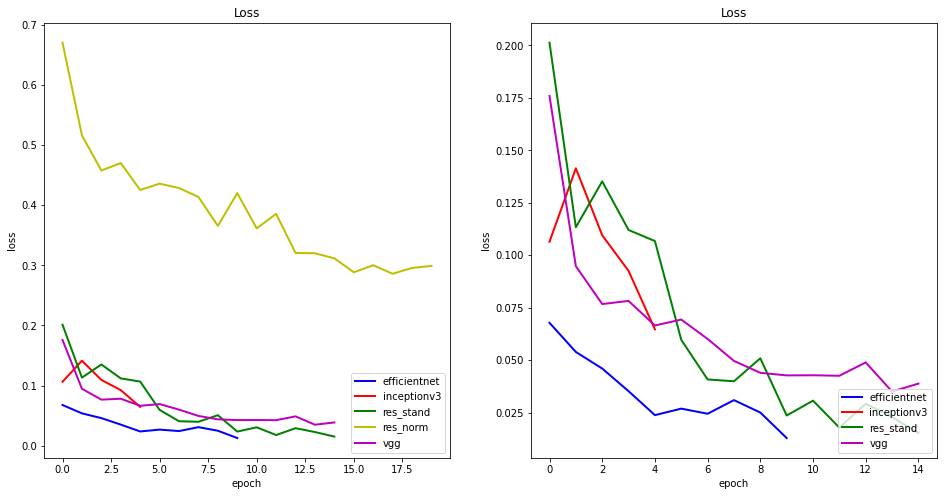

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  
plt.subplot(1,2,1)
plt.plot(efn['loss'], color="b", linewidth=2)
plt.plot(incep['loss'], color="r", linewidth=2)
plt.plot(res_stand['loss'], color="g", linewidth=2)  
plt.plot(res_norm['loss'], color="y", linewidth=2)  
plt.plot(vgg['loss'], color="m", linewidth=2) 

plt.title('Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'res_norm', 'vgg'], loc='lower right')  

plt.subplot(1,2,2)
plt.plot(efn['loss'], color="b", linewidth=2)
plt.plot(incep['loss'], color="r", linewidth=2)
plt.plot(res_stand['loss'], color="g", linewidth=2)  
plt.plot(vgg['loss'], color="m", linewidth=2) 

plt.title('Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'vgg'], loc='lower right') 
plt.show()

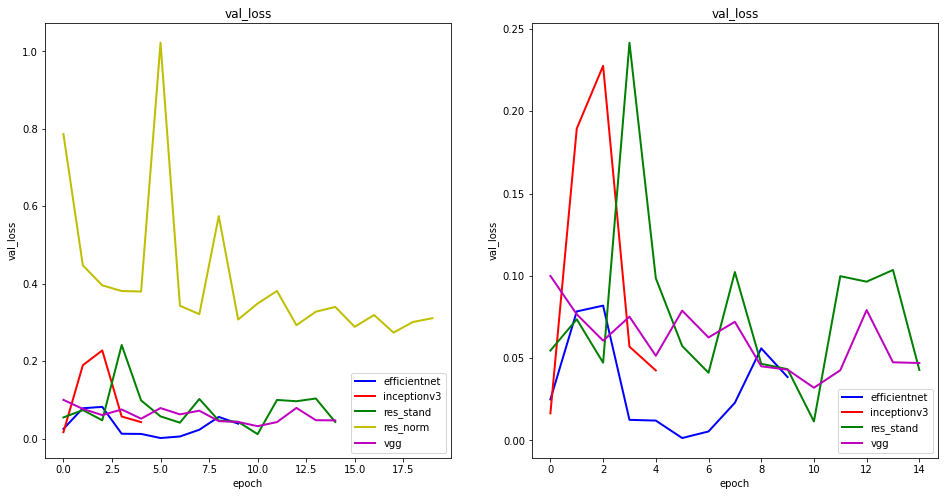

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  
plt.subplot(1,2,1)
plt.plot(efn['val_loss'], color="b", linewidth=2)
plt.plot(incep['val_loss'], color="r", linewidth=2)
plt.plot(res_stand['val_loss'], color="g", linewidth=2)  
plt.plot(res_norm['val_loss'], color="y", linewidth=2)  
plt.plot(vgg['val_loss'], color="m", linewidth=2) 

plt.title('val_loss')  
plt.ylabel('val_loss')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'res_norm', 'vgg'], loc='lower right')  

plt.subplot(1,2,2)
plt.plot(efn['val_loss'], color="b", linewidth=2)
plt.plot(incep['val_loss'], color="r", linewidth=2)
plt.plot(res_stand['val_loss'], color="g", linewidth=2)  
plt.plot(vgg['val_loss'], color="m", linewidth=2) 

plt.title('val_loss')  
plt.ylabel('val_loss')  
plt.xlabel('epoch')  
plt.legend(['efficientnet', 'inceptionv3', 'res_stand', 'vgg'], loc='lower right') 
plt.show()

In [ ]:
import pandas as pd 
efn = [0.011287834495306015, 0.9962499737739563, 1828.9590902328491]
inception = [0.023700179532170296, 0.9975000023841858, 2016.7430481910706]
res_stand = [0.08243097364902496, 0.9975000023841858, 2951.790164232254]
vgg = [0.04144008085131645, 0.9837499856948853, 3096.4909472465515]
scores = pd.DataFrame([
                       efn,
                       inception,
                       res_stand,
                       vgg],
                      index=["EfficientNet", "Inception", "Resnet50", "VGG19"],
                      columns=["Loss", "Accuracy", "Time"])
scores = scores.reset_index()
print(scores)

          index      Loss  Accuracy         Time
0  EfficientNet  0.011288   0.99625  1828.959090
1     Inception  0.023700   0.99750  2016.743048
2      Resnet50  0.082431   0.99750  2951.790164
3         VGG19  0.041440   0.98375  3096.490947


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


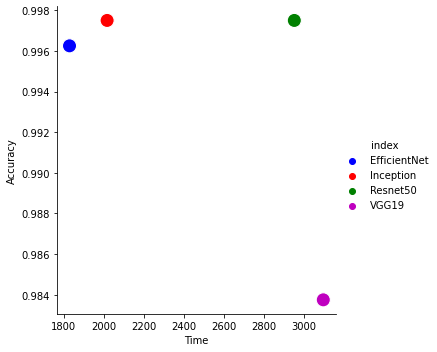

In [ ]:
sns.relplot(data=scores, x="Time", y="Accuracy", 
            hue="index", 
            palette=["b","r","g","m"], s=200)